# CDC NDI Mortality - Syft Duet - Data Scientist 🥁

This worksheet is intended to illustrate functionality of a shared statistical platform, using a partially synthetic public-use dataset that mirrors the restricted-use dataset. Ultimately, these processes would apply to the restricted-use data.

Sample data compiled from the public-use linked mortality files share at https://www.cdc.gov/nchs/data-linkage/mortality.htm provided by the National Center for Health Statistics (NCHS).

## PART 1: Connect to a Remote Duet Server

As the Data Scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server in their Notebook.

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. The code will look like this, importantly with their real Server ID.

```
import syft as sy
duet = sy.duet('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
```

This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.

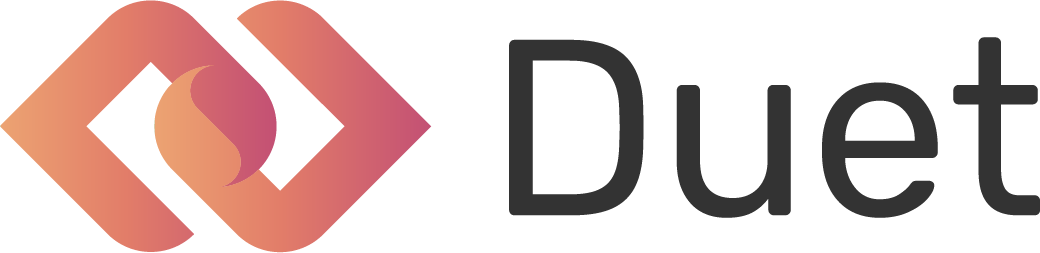

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [1]:
import syft as sy

duet = sy.join_duet(loopback=True)

### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until the next checkpoint.

In [2]:
sy.load("pandas")
sy.load("statsmodels")
sy.load("numpy")

In [3]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 366f228c348e4ad9894ee0380d7a86a2>,[df],,<class 'pandas.core.frame.DataFrame'>
1,<UID: 1e315cab07d9410cabfc64afa48c9437>,[preds],,<class 'numpy.ndarray'>


In [4]:
df_ptr = duet.store["df"]

In [5]:
cancer_ptr = df_ptr[(df_ptr["UCOD_LEADING"] == 2) & (df_ptr["ELIGSTAT"] == 1)]

In [6]:
heart_ptr = df_ptr[(df_ptr["UCOD_LEADING"] == 1) & (df_ptr["ELIGSTAT"] == 1)]

In [7]:
# Compute simple means and for the cancer and heart subgroups that had diabetes
# listed as a multiple cause of death
cancer_mean_ptr = cancer_ptr["DIABETES"].mean()

In [8]:
# Compute simple means and standard deviations for the cancer and heart subgroups
# that had diabetes as a multiple cause of death
heart_mean_ptr = heart_ptr["DIABETES"].mean()

In [9]:
cancer_mean = cancer_mean_ptr.get(request_block=True, delete_obj=False)
cancer_mean

0.054508406668901443

In [10]:
heart_mean = heart_mean_ptr.get(request_block=True, delete_obj=False)
heart_mean

0.12796705961227417

In [11]:
# Sample means data should account for weights. Write a custom function that uses the weights.


def weighted_mean(dx, key, weight_key="WGT_NEW"):
    w = dx[weight_key]
    v = dx[key]
    return (w * v).sum() / w.sum()


cancer_wm_ptr = weighted_mean(cancer_ptr, "DIABETES")
heart_wm_ptr = weighted_mean(heart_ptr, "DIABETES")

In [12]:
# Example of a small subgroup (sample size = 6)
# Cancer-deaths from males aged 47 who died in 2015
# We should check for small cell sizes here
subgroup = cancer_ptr[
    (cancer_ptr["SEX"] == 1)
    & (cancer_ptr["AGE_P"] == 47)
    & (cancer_ptr["DODYEAR"] == 2015)
]
print(subgroup["DIABETES"].mean().get(request_block=True, delete_obj=False))
print(weighted_mean(subgroup, "DIABETES").get(request_block=True, delete_obj=False))
print(len(subgroup))

# These stats are problematic, as the subgroup is too small to report (n=6)
subgroup.get(request_block=True, delete_obj=False)

0.1666666716337204
0.1967846006155014
6


,data_year,ID_PERSON,SEX,AGE_P,STRATUM,PSU,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,DODQTR,DODYEAR,WGT_NEW,SA_WGT_NEW
43063,1998,19980303850101,1,47,84,2,1,1.0,2.0,0.0,0.0,2.0,2015.0,3666.0,4214.0
93051,1999,19990600490101,1,47,298,2,1,1.0,2.0,1.0,1.0,2.0,2015.0,4333.0,21608.0
111480,2000,20000260900102,1,47,336,1,1,1.0,2.0,0.0,0.0,1.0,2015.0,4034.0,15016.0
262634,2005,20050103300101,1,47,314,1,1,1.0,2.0,0.0,0.0,4.0,2015.0,5676.0,12845.0
308083,2006,20060401920101,1,47,265,1,1,1.0,2.0,0.0,0.0,3.0,2015.0,2637.0,3258.0
438672,2011,20110521610101,1,47,13,1,1,1.0,2.0,0.0,0.0,4.0,2015.0,1673.0,7003.0


In [13]:
# import statsmodels.api as sm
# from statsmodels.genmod.generalized_linear_model import GLM
# from statsmodels.genmod.families import Binomial

# # Drop any missing values in the dataset (those under 18)
# df = df.dropna(subset=["MORTSTAT"])
# # Keep only the eligible portion
# df = df[df.ELIGSTAT == 1]

# # Ignore people > 80
# df = df[df.AGE_P <= 80]

# # A person is alive if MORTSTAT==0
# df["is_alive"] = df.MORTSTAT == 0

# # Assign a helpful column for sex (0==male, 1==female)
# df["sex"] = "male"
# df.loc[df.SEX == 2, "sex"] = "female"

# x = df["AGE_P"]
# _x = sm.add_constant(x)
# _y = df["is_alive"]

# results = GLM(_y, _x, family=Binomial()).fit()
# print(results.summary())

In [14]:
# see available remote statsmodel API
duet.statsmodels

Module:
	.api -> Module:
		.add_constant -> <syft.ast.callable.Callable object at 0x0000017CEFB61E20>

	.genmod -> Module:
		.generalized_linear_model -> Module:
			.GLM -> <syft.ast.klass.Class object at 0x0000017CEFB619A0>
			.GLMResults -> <syft.ast.klass.Class object at 0x0000017CEFB61A00>
			.GLMResultsWrapper -> <syft.ast.klass.Class object at 0x0000017CEFB61A60>

		.families -> Module:
			.Binomial -> <syft.ast.klass.Class object at 0x0000017CEFB61B20>
			.Gamma -> <syft.ast.klass.Class object at 0x0000017CEFB61B80>
			.Gaussian -> <syft.ast.klass.Class object at 0x0000017CEFB61BE0>
			.InverseGaussian -> <syft.ast.klass.Class object at 0x0000017CEFB61C40>
			.NegativeBinomial -> <syft.ast.klass.Class object at 0x0000017CEFB61CA0>
			.Poisson -> <syft.ast.klass.Class object at 0x0000017CEFB61D00>
			.Tweedie -> <syft.ast.klass.Class object at 0x0000017CEFB61D60>


	.iolib -> Module:
		.summary -> Module:
			.Summary -> <syft.ast.klass.Class object at 0x0000017CEFB61AC0>



In [15]:
# Drop any missing values in the dataset (those under 18)
df = df_ptr.dropna(subset=["MORTSTAT"])
# Keep only the eligible portion
df = df[df["ELIGSTAT"] == 1]

# Ignore people > 80
df = df[df["AGE_P"] <= 80]

# A person is alive if MORTSTAT==0
df["is_alive"] = df["MORTSTAT"] == 0

# Assign a helpful column for sex (0==male, 1==female)
df["sex"] = "male"
df.loc[df["SEX"] == 2, "sex"] = "female"

x_ptr = df["AGE_P"]
_x_ptr = duet.statsmodels.api.add_constant(x_ptr)
_y_ptr = df["is_alive"]

model = duet.statsmodels.genmod.generalized_linear_model.GLM(
    _y_ptr, _x_ptr, family=duet.statsmodels.genmod.families.Binomial()
)
results = model.fit()

In [16]:
remote_summary = results.get(request_block=True, delete_obj=False)
print(remote_summary)

            Generalized Linear Model Regression Results            
Dep. Variable:  ,is_alive        ,  No. Observations:  ,504237     
Model:          ,GLM             ,  Df Residuals:      ,504235     
Model Family:   ,Binomial        ,  Df Model:          ,     1     
Link Function:  ,logit           ,  Scale:             ,  1.0000   
Method:         ,IRLS            ,  Log-Likelihood:    ,-1.3460e+05
Date:           ,Tue, 04 May 2021,  Deviance:          ,2.6919e+05 
Time:           ,18:25:33        ,  Pearson chi2:      ,5.53e+05   
No. Iterations: ,7               ,                     ,           
Covariance Type:,nonrobust       ,                     ,           
     ,   coef   , std err ,    z    ,P>|z| ,  [0.025 ,  0.975] 
const,    6.3214,    0.022,  281.723, 0.000,    6.277,    6.365
AGE_P,   -0.0773,    0.000, -212.030, 0.000,   -0.078,   -0.077


In [17]:
import pandas as pd
import io

summary_df = pd.read_csv(io.StringIO(remote_summary), names=[1, 2, 3, 4, 5, 6, 7])
summary_df

,1,2,3,4,5,6,7
0,Generalized Linear Model Regressio...,NaN,NaN,NaN,NaN,NaN,NaN
1,Dep. Variable:,is_alive,No. Observations:,504237,NaN,NaN,NaN
2,Model:,GLM,Df Residuals:,504235,NaN,NaN,NaN
3,Model Family:,Binomial,Df Model:,1,NaN,NaN,NaN
4,Link Function:,logit,Scale:,1.0000,NaN,NaN,NaN
5,Method:,IRLS,Log-Likelihood:,-1.3460e+05,NaN,NaN,NaN
6,Date:,Tue,04 May 2021,Deviance:,2.6919e+05,NaN,NaN
7,Time:,18:25:33,Pearson chi2:,5.53e+05,NaN,NaN,NaN
8,No. Iterations:,7,,,NaN,NaN,NaN
9,Covariance Type:,nonrobust,,,NaN,NaN,NaN


In [18]:
x = x_ptr.get(request_block=True, delete_obj=False)

In [19]:
_y = _y_ptr.get(request_block=True, delete_obj=False)

In [20]:
sex = df["sex"].get(request_block=True, delete_obj=False)

In [21]:
# TODO finish adding range and dynamic object attributes for remote invocation
predict_x = range(x.min(), x.max() + 1, 1)
# preds = results.predict(sm.add_constant(predict_x))

In [22]:
# request the results.predict calculation and retrieve the results

In [23]:
preds = duet.store["preds"].get(request_block=True, delete_obj=False)

In [24]:
plot_df = pd.DataFrame()

In [25]:
plot_df["AGE_P"] = x
plot_df["is_alive"] = _y
plot_df["sex"] = sex

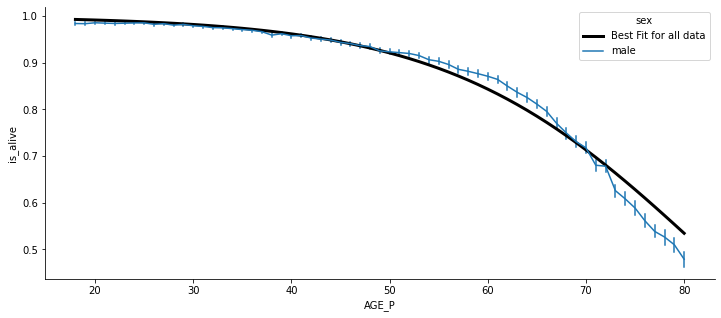

In [26]:
try:
    import pylab as plt
    import seaborn as sns

    plt.figure(figsize=(12, 5))
    plt.plot(predict_x, preds, "k", lw=3, label="Best Fit for all data")
    sns.lineplot(data=plot_df, x="AGE_P", y="is_alive", hue="sex", err_style="bars")
    sns.despine()
except ImportError:
    print("Cant import seaborn try:\n!pip install seaborn")